In [889]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import lars_path
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

In [890]:
D = pd.read_csv('./ADNIAVLTAmyloidClassification.csv')
dct = pd.read_csv('./ADNIAVLTAmyloidClassificationDictionary.csv')

In [891]:
D.loc[D.genotype < 3, 'genotype'] = 1
D.loc[(D.genotype > 1) & (D.genotype < 5), 'genotype'] = 2
D.loc[D.genotype > 4, 'genotype'] = 3

In [892]:
D.loc[D.dx == 2, 'dx'] = 0
D.loc[D.dx == 1, 'dx'] = 0
D.loc[D.dx == 3, 'dx'] = 1

In [893]:
D.loc[D.abeta6mcut == 2, 'abeta6mcut'] = 0

In [894]:
D.loc[D.t6sum < 0, 't6sum'] = 0
D.loc[D.t7sum < 0, 't7sum'] = 0

In [895]:
D.loc[D.sex == 2, 'sex'] = 0

In [896]:
D['ifr'] = D.t1sum + D.t2sum + D.t3sum + D.t4sum + D.t5sum + D.t6sum + D.t7sum

D.drop(['t1sum', 't2sum', 't3sum', 't4sum', 't5sum', 't6sum', 't7sum'], axis=1, inplace=True)
D.drop(['wordlist'], axis=1, inplace=True)

In [897]:
Z = norm.ppf
 
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

D['d'] = np.nan
D['beta'] = np.nan
D['c'] = np.nan
D['ad'] = np.nan
for i, r in D.iterrows():
    h, f = D.loc[0, ['drec_hits', 'drec_fa']]
    out = SDT(h, 15-h, f, 15-f)
    D.loc[i, 'd'] = out['d']
    D.loc[i, 'beta'] = out['beta']
    D.loc[i, 'c'] = out['c']
    D.loc[i, 'ad'] = out['Ad']

In [898]:
D.drop(['drec_hits', 'drec_fa'], axis=1, inplace=True)
D

,rid,month,age,sex,edu,genotype,abeta6m,abeta6mcut,dx,distsum,ifr,d,beta,c,ad
0,5,0,73.7,0,16,2,116.0,0,0,4,46,3.335001,0.574077,-0.166414,0.990818
1,5,6,74.2,0,16,2,116.0,0,0,2,44,3.335001,0.574077,-0.166414,0.990818
2,5,12,74.7,0,16,2,136.0,0,0,5,51,3.335001,0.574077,-0.166414,0.990818
3,8,0,84.5,1,18,1,268.0,1,0,5,70,3.335001,0.574077,-0.166414,0.990818
4,8,6,85.0,1,18,1,268.0,1,0,6,53,3.335001,0.574077,-0.166414,0.990818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,1421,6,74.9,1,12,3,133.0,0,1,6,35,3.335001,0.574077,-0.166414,0.990818
935,1421,12,75.4,1,12,3,138.0,0,1,3,42,3.335001,0.574077,-0.166414,0.990818
936,1421,18,75.9,1,12,3,138.0,0,1,4,28,3.335001,0.574077,-0.166414,0.990818
937,1423,0,69.4,0,19,3,139.0,0,1,4,24,3.335001,0.574077,-0.166414,0.990818


In [899]:
ct = make_column_transformer(
      (StandardScaler(), ['age', 'edu', 'abeta6m', 'ifr', 'distsum']),
      (OneHotEncoder(), ['genotype']),
    remainder='passthrough')

In [900]:
cols = ['age', 'edu', 'abeta6m', 'ifr', 'distsum',
        'protective_factor', 'neutral_factor', 'risk_factor',
        'rid', 'month', 'sex', 'dx', 'abeta6mcut', 'd', 'beta', 'c', 'ad']
df = pd.DataFrame(ct.fit_transform(D), columns=cols)
cols = pd.Index(['rid', 'month', 'sex', 'age', 'edu', 'dx',
                'abeta6m', 'abeta6mcut',
                'protective_factor', 'neutral_factor', 'risk_factor',
                'ifr', 'distsum',  'd', 'beta', 'c', 'ad'])
df = df.loc[:, cols]
df

,rid,month,sex,age,edu,dx,abeta6m,abeta6mcut,protective_factor,neutral_factor,risk_factor,ifr,distsum,d,beta,c,ad
0,5.0,0.0,0.0,-0.335336,0.003754,0.0,-1.149544,0.0,0.0,1.0,0.0,0.146186,-0.040900,3.335001,0.574077,-0.166414,0.990818
1,5.0,6.0,0.0,-0.260536,0.003754,0.0,-1.149544,0.0,0.0,1.0,0.0,0.034992,-1.260113,3.335001,0.574077,-0.166414,0.990818
2,5.0,12.0,0.0,-0.185735,0.003754,0.0,-0.796566,0.0,0.0,1.0,0.0,0.424170,0.568706,3.335001,0.574077,-0.166414,0.990818
3,8.0,0.0,1.0,1.280358,0.708804,1.0,1.533087,0.0,1.0,0.0,0.0,1.480508,0.568706,3.335001,0.574077,-0.166414,0.990818
4,8.0,6.0,1.0,1.355158,0.708804,1.0,1.533087,0.0,1.0,0.0,0.0,0.535363,1.178313,3.335001,0.574077,-0.166414,0.990818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,1421.0,6.0,1.0,-0.155815,-1.406346,0.0,-0.849513,1.0,0.0,0.0,1.0,-0.465379,1.178313,3.335001,0.574077,-0.166414,0.990818
935,1421.0,12.0,1.0,-0.081014,-1.406346,0.0,-0.761268,1.0,0.0,0.0,1.0,-0.076201,-0.650507,3.335001,0.574077,-0.166414,0.990818
936,1421.0,18.0,1.0,-0.006213,-1.406346,0.0,-0.761268,1.0,0.0,0.0,1.0,-0.854556,-0.040900,3.335001,0.574077,-0.166414,0.990818
937,1423.0,0.0,0.0,-0.978622,1.061329,0.0,-0.743619,1.0,0.0,0.0,1.0,-1.076943,-0.040900,3.335001,0.574077,-0.166414,0.990818


In [901]:
X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m'], axis=1), df[['abeta6mcut']]
# X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m', 'dx', 'protective_factor', 'neutral_factor', 'risk_factor'], axis=1), df[['abeta6mcut']]
# X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m', 'dx', 'protective_factor', 'neutral_factor', 'risk_factor', 'age', 'sex', 'edu'], axis=1), df[['abeta6mcut']]
# X, y = df.drop(['rid', 'month', 'abeta6mcut', 'abeta6m', 'dx', 'protective_factor', 'neutral_factor', 'risk_factor', 'age', 'sex', 'edu', 'c', 'ad', 'beta'], axis=1), df[['abeta6mcut']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train

,sex,age,edu,dx,protective_factor,neutral_factor,risk_factor,ifr,distsum,d,beta,c,ad
240,0.0,0.367790,0.003754,1.0,0.0,1.0,0.0,-1.076943,-1.260113,3.335001,0.574077,-0.166414,0.990818
270,1.0,-0.963662,0.003754,0.0,0.0,0.0,1.0,-0.131798,0.568706,3.335001,0.574077,-0.166414,0.990818
760,0.0,-0.350296,1.413854,0.0,0.0,0.0,1.0,0.034992,-0.040900,3.335001,0.574077,-0.166414,0.990818
721,1.0,0.053627,0.708804,1.0,0.0,1.0,0.0,0.590960,0.568706,3.335001,0.574077,-0.166414,0.990818
39,0.0,0.038667,0.003754,0.0,1.0,0.0,0.0,1.758492,1.178313,3.335001,0.574077,-0.166414,0.990818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,1.414999,0.003754,1.0,0.0,1.0,0.0,-0.576572,-1.260113,3.335001,0.574077,-0.166414,0.990818
192,0.0,-0.649499,1.413854,0.0,0.0,1.0,0.0,1.146928,-0.650507,3.335001,0.574077,-0.166414,0.990818
629,0.0,1.235477,-1.053821,1.0,0.0,1.0,0.0,-0.465379,-0.650507,3.335001,0.574077,-0.166414,0.990818
559,0.0,1.175637,-0.348771,0.0,0.0,0.0,1.0,-1.132540,0.568706,3.335001,0.574077,-0.166414,0.990818


In [902]:
lg = LogisticRegression(random_state=0,  max_iter=1000).fit(X_train, np.ravel(y_train))

In [903]:
def precision_recall(clf):
    y_score = clf.decision_function(X_test)
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
def show_precision_recall_curve(clf):
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision));

In [904]:
precision_recall(lg)


Average precision-recall score: 0.93


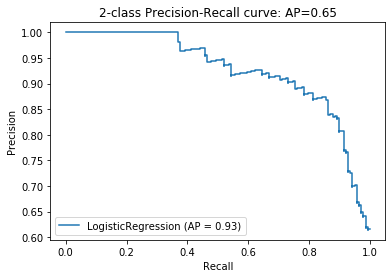

In [905]:
show_precision_recall_curve(lg)

In [906]:
svc = svm.SVC(random_state=0)
svc.fit(X_train, np.ravel(y_train));

In [907]:
precision_recall(svc)

Average precision-recall score: 0.93


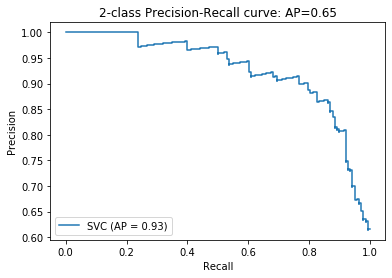

In [908]:
show_precision_recall_curve(svc)

In [909]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

/Users/alex/miniconda3/envs/cs273a/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [910]:
precision_recall(gbc)

Average precision-recall score: 0.91


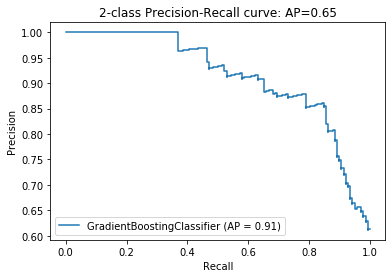

In [911]:
show_precision_recall_curve(gbc)

.

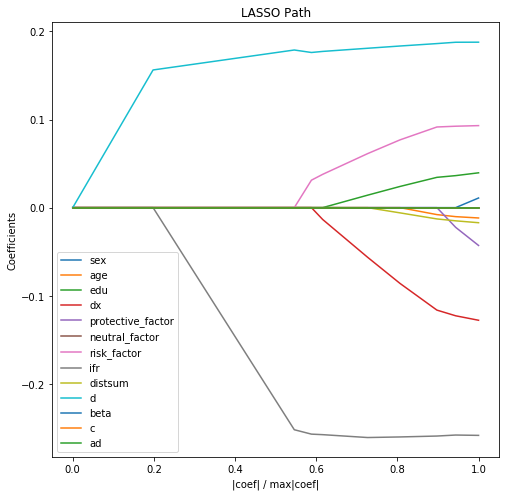

In [912]:
reg = LassoLars(alpha=.1)
_, _, coefs = lars_path(X.to_numpy(), np.ravel(y), method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(8,8))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
# plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(labels=X.columns.to_numpy())
plt.show()